# Analysis of Respiratory Data during Video-EEG Monitoring of all patients

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import resample
import seaborn as sns

from preepiseizures.src import Patient, biosignal_processing
import Respiration_2023 as resp

In [2]:
patient_list = [pat.split('_')[0] for pat in os.listdir('data/respiration/') if pat.endswith('corr_points_all.parquet')]
len(patient_list)

37

In [3]:

def quality_check(x):
    if len(x) > 750:
        if (x['ECG'].std() < 50) & (x['ECG'].std() > 5):
            return x
    
def get_respiratory_rates(data_part):

    resp_rate, resp_times = [], []
    # temporal discontinuities are respected
    time_jumps = np.where(data_part['datetime'].diff().dt.total_seconds().values > 0.02)[0]
    time_jumps = np.hstack((0, time_jumps, len(data_part)))
    # 
    for i in range(len(time_jumps)-1):
        resp_rate_, resp_times_ = biosignal_processing.resp_rate(data_part.iloc[time_jumps[i]:time_jumps[i+1]]['RESP'].values, 80)
        resp_rate.append(resp_rate_)
        resp_times.append(resp_times_ + time_jumps[i])
    
    resp_rate = np.hstack(resp_rate)
    resp_times = np.hstack(resp_times)
    resp_timestamps = data_part.iloc[resp_times]['datetime']
    resp_df = pd.DataFrame(resp_rate, index=resp_timestamps, columns=['resp_rate'])
    resp_df['datetime'] = resp_df.index
    
    return resp_df

## Correlation vs Breathing Rate with only matching values (to the second)

In [4]:

dict_bpm = {0:[0, 4, '0-4'], 1:[4, 8, '4-8'], 2:[8, 12, '8-12'], 
         3:[12, 16, '12-16'], 4:[16, 20, '16-20'], 5:[20, 24, '20-24'], 
         6:[24, 28, '24-28'], 7:[28, 2500, '28+']}

all_data = pd.DataFrame()

# get data
for patient in patient_list:
    print(patient)
    if patient == 'WVKA':
        print('This patient has no data with sufficient quality')
        continue

    # get cardiorespiratory data
    data_path = f'data{os.sep}respiration{os.sep}{patient}_all_respiration_data.parquet'
    data = pd.read_parquet(data_path)
    # print('Length of data ', len(data))

    # get correlation points
    corr_points = pd.read_parquet(f'data{os.sep}respiration{os.sep}{patient}_respiration_corr_points_all.parquet')
    time_corr_points = [pd.date_range(corr_points.index[i], corr_points.index[i]+pd.Timedelta(seconds=60), periods=10) for i in range(len(corr_points.index))]
    corr_points = pd.DataFrame(np.hstack(corr_points.values), index=np.hstack(time_corr_points))
    # print('Number of corr points ', len(corr_points))
    # truncate the data to the time of the correlation points
    data_part = data.loc[data['datetime'].between(corr_points.index[0], corr_points.index[-1])].copy()
    # print('Length of data part ', len(data_part))
    # create datetime column
    corr_points['datetime'] = corr_points.index
    # Remove periods of bad quality
    # see in segments of 10 seconds
    # if the std is too high, remove the whole segment
    # if the std is too low, remove the whole segment
    data_part['datetime'] = data_part['datetime'].astype('datetime64[ns]')
    try:
        data_quality = data_part.resample(on='datetime', rule='10S').apply(quality_check)
    except Exception as e:
        print(e)
        continue
    data_quality['datetime'] = data_part.loc[data_part.index.isin(data_quality.index)]['datetime']
    # print('Length of data quality ', len(data_quality))
    # get respiratory rate
    resp_df = get_respiratory_rates(data_part)
    # print('Length of resp_df ', len(resp_df))
    # get quality times
    data_quality_times = data_quality['datetime'].dt.round('1S').unique()
    corr_points['seconds'] = corr_points['datetime'].dt.round('1S')
    data_quality_corr = corr_points.loc[corr_points['seconds'].isin(data_quality_times)].copy()
    # print('Length of data quality corr before resp rate ', len(data_quality_corr))
    resp_df['seconds'] = resp_df['datetime'].dt.round('1S')
    data_quality_rate = resp_df.loc[resp_df['seconds'].isin(data_quality_times)].copy()
    data_quality_rate.fillna(method='ffill', inplace=True)
    data_quality_corr.reset_index(inplace=True, drop=True)
    data_quality_rate.reset_index(inplace=True, drop=True)
    data_quality_corr = data_quality_corr.merge(data_quality_rate, on='seconds')
    # print('Length of data quality corr ', len(data_quality_corr))
    if len(data_quality_corr) == 0:
        print('This patient has no data with sufficient quality')
    data_quality_corr['bpm'] = ''
    for i in range(8):
        data_quality_corr.loc[(data_quality_corr['resp_rate'] < dict_bpm[i][1]) & (data_quality_corr['resp_rate'] >= dict_bpm[i][0]), 'bpm'] = dict_bpm[i][2]
    data_quality_corr
    data_quality_corr.rename(columns={0:'IO Correlation'}, inplace=True)
    data_quality_corr.sort_values(by='resp_rate', inplace=True)

    data_quality_corr['patient'] = patient
    all_data = pd.concat((all_data, data_quality_corr), axis=0)
    # print('all good so far')



QDST


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


PRBQ


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


CNSV
<class 'pandas.core.indexes.base.Index'>
EXRE


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


CJMJ


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


MQWA


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


BLIW


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


UIJU


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SYRH


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TZPY


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


RMJL


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IZZD


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


YWJN


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


OFUF


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


KHTG
<class 'pandas.core.indexes.base.Index'>
LDXH


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


VNVW


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


BSEA


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


MHDG
QJBW


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


YIVL


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


LGOH


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NJML


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


WOSQ


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


DDEX


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


WMWV
<class 'pandas.core.indexes.base.Index'>
XEUD


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


WVKA
This patient has no data with sufficient quality
SZLU
RAFI


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


PGSE
WZFI


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


UDZG


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IQCX


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


OQQA


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


PZEF


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


AGGA


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
#all_data.dropna(inplace=True)
all_data

,IO Correlation,datetime_x,seconds,resp_rate,datetime_y,bpm,patient
2654,-0.135379,2022-07-06 05:06:39.741827215,2022-07-06 05:06:40,2.646086,2022-07-06 05:06:40.325161535,0-4,PRBQ
2424,0.479112,2022-07-06 00:45:39.739697653,2022-07-06 00:45:40,2.886350,2022-07-06 00:45:40.323031973,0-4,PRBQ
2920,-0.710527,2022-07-06 10:38:39.744536083,2022-07-06 10:38:40,2.903811,2022-07-06 10:38:40.327870403,0-4,PRBQ
3094,-0.200063,2022-07-06 14:03:39.746208727,2022-07-06 14:03:40,3.187251,2022-07-06 14:03:40.329543047,0-4,PRBQ
3160,0.039975,2022-07-06 15:30:39.734418580,2022-07-06 15:30:40,3.368421,2022-07-06 15:30:40.330252901,0-4,PRBQ
...,...,...,...,...,...,...,...
67,0.522675,2021-12-14 15:39:44.217163618,2021-12-14 15:39:44,26.158038,2021-12-14 15:39:43.910263830,24-28,AGGA
595,0.323535,2021-12-15 04:46:57.557195493,2021-12-15 04:46:58,31.441048,2021-12-15 04:46:58.440616841,28+,AGGA
39,0.326483,2021-12-14 09:33:37.555020375,2021-12-14 09:33:38,32.085561,2021-12-14 09:33:37.963397801,28+,AGGA
17,-0.133400,2021-12-14 09:04:37.556676614,2021-12-14 09:04:38,54.223969,2021-12-14 09:04:37.952553962,28+,AGGA


## Respiration Analysis in ECG Quality Intervals

In [12]:
fig = px.scatter(all_data, x='IO Correlation', y='resp_rate', title=f'correlation vs respiration rate', color='patient')
fig.show()

In [30]:
#fig = px.line(data_part.iloc[-1500000:-950000], x='datetime', y=['ECG', 'RESP'])
#fig.show()

In [41]:
fig = px.line(data_quality_corr, y='resp_rate',title=f'{patient} respiration')
#for i in range(len(patient_info.seizure_table)):
#    fig.add_vline(patient_info.seizure_table.iloc[i]['Timestamp'], line_width=3, line_dash='dash', line_color='red')
fig.show()

In [13]:
data_quality_corr = all_data.copy()

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight

/Users/saraiva/dev

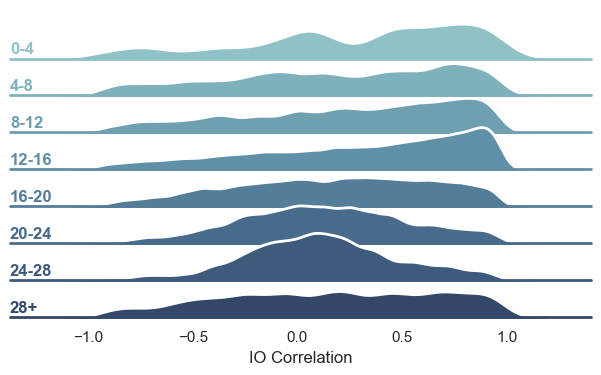

In [19]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(data_quality_corr, row="bpm", hue="bpm", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'IO Correlation',
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'IO Correlation', clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)



g.map(label, 'IO Correlation')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)


plt.savefig(f'data{os.sep}figures{os.sep}all_respiration_rate_vs_correlation.pdf', dpi=300, bbox_inches='tight')


In [64]:
from scipy.stats import mannwhitneyu, kruskal, ks_2samp, friedmanchisquare



mannwhitneyu(
        data_quality_corr.groupby('bpm').get_group('8-12')['IO Correlation'].values,
        
        data_quality_corr.groupby('bpm').get_group('12-16')['IO Correlation'].values)
        

MannwhitneyuResult(statistic=25060073.0, pvalue=1.763886113789885e-12)

In [107]:
# table of p-values, median, mean, std, n

def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

groups = [data_quality_corr.groupby('bpm').get_group(dict_bpm[i][2])['IO Correlation'].values for i in range(8)]
for i in dict_bpm.keys():
    
    data_interval = data_quality_corr.groupby('bpm').get_group(dict_bpm[i][2])
    skew = np.round(data_interval['IO Correlation'].skew(), 2)
    mean = np.round(data_interval['IO Correlation'].mean(), 2)
    median = np.round(data_interval['IO Correlation'].median(), 2)
    mode_ = np.round(data_interval['IO Correlation'].mode(), 2)
    counts, post = np.histogram(data_interval['IO Correlation'].values, bins=20)
    mode_ = np.round(post[np.argmax(counts)], 6)
    kk = mannwhitneyu(data_quality_corr.groupby('bpm').get_group(dict_bpm[i][2])['IO Correlation'].values, data_quality_corr.loc[data_quality_corr['bpm'] != dict_bpm[i][2], 'IO Correlation']).pvalue
    #d, res = cliffs_delta(data_quality_corr.groupby('bpm').get_group(dict_bpm[i][2])['IO Correlation'].values, data_quality_corr.loc[data_quality_corr['bpm'] != dict_bpm[i][2], 'IO Correlation'])
    #print(d,res)
    print(f'Interval {dict_bpm[i][2]} N = {len(data_interval)} {skew=} | {mean=} | {mode_=} | {median=} | {kk=} | {effect_size=}')

Interval 0-4 N = 149 skew=-0.63 | mean=0.28 | mode_=0.404771 | median=0.42 | kk=0.05084667860116777 | effect_size=KstestResult(statistic=0.06943755469379753, pvalue=0.0007690145367568967, statistic_location=-0.016002792724715834, statistic_sign=1)
Interval 4-8 N = 1439 skew=-0.33 | mean=0.18 | mode_=0.697149 | median=0.21 | kk=0.05151546314600077 | effect_size=KstestResult(statistic=0.06943755469379753, pvalue=0.0007690145367568967, statistic_location=-0.016002792724715834, statistic_sign=1)
Interval 8-12 N = 4334 skew=-0.46 | mean=0.23 | mode_=0.795399 | median=0.31 | kk=9.700451428754328e-05 | effect_size=KstestResult(statistic=0.06943755469379753, pvalue=0.0007690145367568967, statistic_location=-0.016002792724715834, statistic_sign=1)
Interval 12-16 N = 12459 skew=-0.57 | mean=0.29 | mode_=0.798129 | median=0.39 | kk=1.7768686445693926e-138 | effect_size=KstestResult(statistic=0.06943755469379753, pvalue=0.0007690145367568967, statistic_location=-0.016002792724715834, statistic_sig

In [67]:
groups = [data_quality_corr.groupby('bpm').get_group(dict_bpm[i][2])['IO Correlation'].values for i in range(8)]
friedmanchisquare(*groups)

ValueError: Unequal N in friedmanchisquare.  Aborting.

In [79]:
import statistics

data_quality_corr.groupby('bpm').apply(lambda x: statistics.mode(x['IO Correlation']))



bpm
0-4     -0.135379
12-16    0.468242
16-20    0.284963
20-24    0.625339
24-28   -0.040033
28+     -0.389059
4-8      0.709798
8-12    -0.894684
dtype: float64

In [99]:
counts, post = np.histogram(data_interval['IO Correlation'].values, bins=10)
post[np.argmax(counts)]

0.7981291919099249

0.8578186813111435